In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics, svm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

import lightgbm

import re
import datetime
import itertools

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    rmse = metrics.mean_squared_error(test_labels, predictions, squared=False)
    print('Model Performance')
    print('RMSE: {:0.4f} degrees.'.format(rmse))



In [3]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")

    grad = np.where(y_true<high_score,
                        np.where(residual<0,
                                     -2*10.0*residual,
                                     -2*residual),
                        np.where(residual>0,
                                     -2*10.0*residual,
                                     -2*residual))
    hess = np.where(y_true<high_score,
                        np.where(residual<0,
                                     2*10.0,
                                     2.0),
                        np.where(residual>0,
                                     2*10.0,
                                     2.0))

    return grad, hess


In [4]:
def experimental_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")


In [5]:
def custom_scaling_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    
    grad = np.where(y_true<high_score,
                        np.where(residual<0,
                                     -2*(high_score-y_true)*residual,
                                     -2*residual/(high_score-y_true)),
                        np.where(residual>=0,
                                     -2*(y_true-high_score)*residual,
                                     -2*residual/(y_true-high_score)))
    hess = np.where(y_true<high_score,
                        np.where(residual<0,
                                     2*(high_score-y_true),
                                     2.0/(high_score-y_true)),
                        np.where(residual>=0,
                                     2*(y_true-high_score),
                                     2.0/(y_true-high_score)))

    return grad, hess




In [6]:
def point_test(model, df, verbose=False):
    df.loc[:,'predicted_score_own'] = model.predict(df[features])

    max_pred = df.groupby(['week', 'position', 'playerid_own'])[['predicted_score_own']].mean()
    max_pred = max_pred.groupby(['week', 'position'])[['predicted_score_own']].max()
    max_pred = max_pred.reset_index().rename(columns={'predicted_score_own':'max_predicted_score'})
    df = pd.merge(df, max_pred, on=['week', 'position'], how='left')

    picks = df.groupby(['week','position', 'playerid_own'])[['max_score_own', 'score_own', 
                                                             'predicted_score_own', 'max_predicted_score']].mean().reset_index()
    picks = picks.loc[picks.predicted_score_own == picks.max_predicted_score]
    week =picks.week.unique()
    pos = picks.position.unique()
    combs = itertools.product(week, pos)
    back = pd.DataFrame()
    # to avoid picking multiple players when predicted scores match
    for i in combs:
        temp = picks[(picks.week == i[0]) &  (picks.position == i[1])]
        out = temp.iloc[0,:].to_frame().T
        back = pd.concat([back, out], axis=0)
    
    picks = back

    picks['missed_points'] = picks['max_score_own'] - picks['score_own']
    picks = picks.groupby('week')[['missed_points', 'score_own']].sum().reset_index()

    out = picks['score_own'][0] * 3
    for i in range(1,7):
        out += picks['score_own'][i] * 2
    out += picks['score_own'][7]*3
    
    if verbose:
        return picks
    else:
        return out


In [7]:
data = pd.read_csv('unstacked.csv', index_col='Unnamed: 0')
data.head()

,gameid,date,playerid_own,max_score_own,average_killsat15_enemytop,average_deathsat15_enemytop,average_assistsat15_enemytop,average_cs_enemytop,average_score_enemytop,average_firstbloodkill_enemytop,average_triplekills_enemytop,average_quadrakills_enemytop,average_pentakills_enemytop,average_gamelength_enemytop,average_visionscore_enemytop,total_games_enemytop,average_killsat15_enemyjng,average_deathsat15_enemyjng,average_assistsat15_enemyjng,average_cs_enemyjng,average_score_enemyjng,average_firstbloodkill_enemyjng,average_triplekills_enemyjng,average_quadrakills_enemyjng,average_pentakills_enemyjng,average_gamelength_enemyjng,average_visionscore_enemyjng,total_games_enemyjng,average_killsat15_enemymid,average_deathsat15_enemymid,average_assistsat15_enemymid,average_cs_enemymid,average_score_enemymid,average_firstbloodkill_enemymid,average_triplekills_enemymid,average_quadrakills_enemymid,average_pentakills_enemymid,average_gamelength_enemymid,average_visionscore_enemymid,total_games_enemymid,average_killsat15_enemybot,average_deathsat15_enemybot,average_assistsat15_enemybot,average_cs_enemybot,average_score_enemybot,average_firstbloodkill_enemybot,average_triplekills_enemybot,average_quadrakills_enemybot,average_pentakills_enemybot,average_gamelength_enemybot,average_visionscore_enemybot,total_games_enemybot,average_killsat15_enemysup,average_deathsat15_enemysup,average_assistsat15_enemysup,average_cs_enemysup,average_score_enemysup,average_firstbloodkill_enemysup,average_triplekills_enemysup,average_quadrakills_enemysup,average_pentakills_enemysup,average_gamelength_enemysup,average_visionscore_enemysup,total_games_enemysup,average_killsat15_teamtop,average_deathsat15_teamtop,average_assistsat15_teamtop,average_cs_teamtop,average_score_teamtop,average_firstbloodkill_teamtop,average_triplekills_teamtop,average_quadrakills_teamtop,average_pentakills_teamtop,average_gamelength_teamtop,average_visionscore_teamtop,total_games_teamtop,average_killsat15_teamjng,average_deathsat15_teamjng,average_assistsat15_teamjng,average_cs_teamjng,average_score_teamjng,average_firstbloodkill_teamjng,average_triplekills_teamjng,average_quadrakills_teamjng,average_pentakills_teamjng,average_gamelength_teamjng,average_visionscore_teamjng,total_games_teamjng,average_killsat15_teammid,average_deathsat15_teammid,average_assistsat15_teammid,average_cs_teammid,average_score_teammid,average_firstbloodkill_teammid,average_triplekills_teammid,average_quadrakills_teammid,average_pentakills_teammid,average_gamelength_teammid,average_visionscore_teammid,total_games_teammid,average_killsat15_teambot,average_deathsat15_teambot,average_assistsat15_teambot,average_cs_teambot,average_score_teambot,average_firstbloodkill_teambot,average_triplekills_teambot,average_quadrakills_teambot,average_pentakills_teambot,average_gamelength_teambot,average_visionscore_teambot,total_games_teambot,score_own,average_killsat15_teamsup,average_deathsat15_teamsup,average_assistsat15_teamsup,average_cs_teamsup,average_score_teamsup,average_firstbloodkill_teamsup,average_triplekills_teamsup,average_quadrakills_teamsup,average_pentakills_teamsup,average_gamelength_teamsup,average_visionscore_teamsup,total_games_teamsup,position
0,ESPORTSTMNT01/1031941,2019-01-19 09:53:50,oe:player:9405c3aff9112c3c60d03b94792877d,34.675,0.328125,0.390625,0.562500,324.125000,20.716875,0.031250,0.031250,0.000000,0.0,2147.140625,43.734375,64.0,0.687500,0.312500,0.968750,181.640625,21.554688,0.156250,0.000000,0.000000,0.0,2147.140625,68.250000,64.0,0.480000,0.280000,0.520000,358.580000,26.731600,0.040000,0.120000,0.020000,0.0,2183.540000,42.660000,50.0,0.250000,0.296875,0.578125,373.687500,25.520625,0.093750,0.062500,0.000000,0.000000,2147.140625,46.843750,64.0,0.275362,0.449275,0.884058,60.014493,16.953913,0.130435,0.0,0.0,0.0,2198.304348,83.202899,69.0,0.519231,0.615385,0.775641,297.775641,17.750385,0.102564,0.012821,0.00641,0.0,2179.794872,30.621795,156.0,0.763636,0.454545,0.963636,163.818182,15.858182,

In [67]:
plt.rcParams.update({'font.size': 15})

<AxesSubplot:xlabel='league', ylabel='count'>

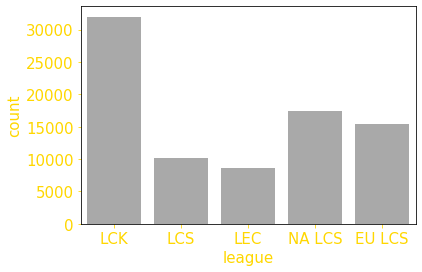

In [68]:
sns.countplot(data=data, x='league', color='darkgrey')

In [8]:
leagues = pd.read_csv('ml_data.csv')
leagues = leagues[['gameid', 'league']].drop_duplicates()

data = pd.merge(data, leagues, on='gameid', how='left')

C:\Users\IsDan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
data.loc[:,'date'] = pd.to_datetime(data.date)
data['year'] = data.date.dt.isocalendar()['year']
data['week'] = data.date.dt.isocalendar()['week']

In [10]:
oe = OrdinalEncoder()
data['position'] = oe.fit_transform(data[['position']])

In [11]:

training = data[data.year < 2022]
testing = data[(data.year == 2022) & (data.league=='LEC')]

In [12]:
training.shape

(79380, 129)

In [13]:
targets = list(data.filter(regex=("^score.*")).columns)
unused = list(data.filter(regex=("^max.*|^playerid")).columns)
features = [x for x in data.columns if x not in (targets + unused + ['date', 'gameid', 'league', 'year', 'week'])]

X = training[features]
y = training['score_own']

high_score = y.quantile(q=0.5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=142)

In [14]:
# make new model on new value
gbm0 = lightgbm.LGBMRegressor(random_state=50, num_leaves=31)

gbm0.fit(
    X,
    y
)

point_test(gbm0, testing, verbose=False)

C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


2292.7

In [15]:
# make new model on new value
gbm1 = lightgbm.LGBMRegressor(random_state=50, num_leaves=31)
gbm1.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse", 'mae'])

gbm1.fit(
    X,
    y
)

point_test(gbm1, testing, verbose=False)

C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


2432.22

In [16]:
# make new model on new value
gbm2 = lightgbm.LGBMRegressor(random_state=142)
gbm2.set_params(**{'objective': custom_scaling_asymmetric_objective}, metrics = ["mse", 'mae'])

gbm2.fit(
    X,
    y,
)

point_test(gbm2, testing)

C:\Users\IsDan\AppData\Local\Temp/ipykernel_6856/1429514116.py:7: RuntimeWarning: divide by zero encountered in true_divide
  -2*residual/(high_score-y_true)),
C:\Users\IsDan\AppData\Local\Temp/ipykernel_6856/1429514116.py:10: RuntimeWarning: divide by zero encountered in true_divide
  -2*residual/(y_true-high_score)))
C:\Users\IsDan\AppData\Local\Temp/ipykernel_6856/1429514116.py:14: RuntimeWarning: divide by zero encountered in true_divide
  2.0/(high_score-y_true)),
C:\Users\IsDan\AppData\Local\Temp/ipykernel_6856/1429514116.py:17: RuntimeWarning: divide by zero encountered in true_divide
  2.0/(y_true-high_score)))


2159.38

In [17]:
knr = KNeighborsRegressor()

knr.fit(X, y)

point_test(knr, testing)

C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


2071.24

In [56]:
COLOR = 'gold'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

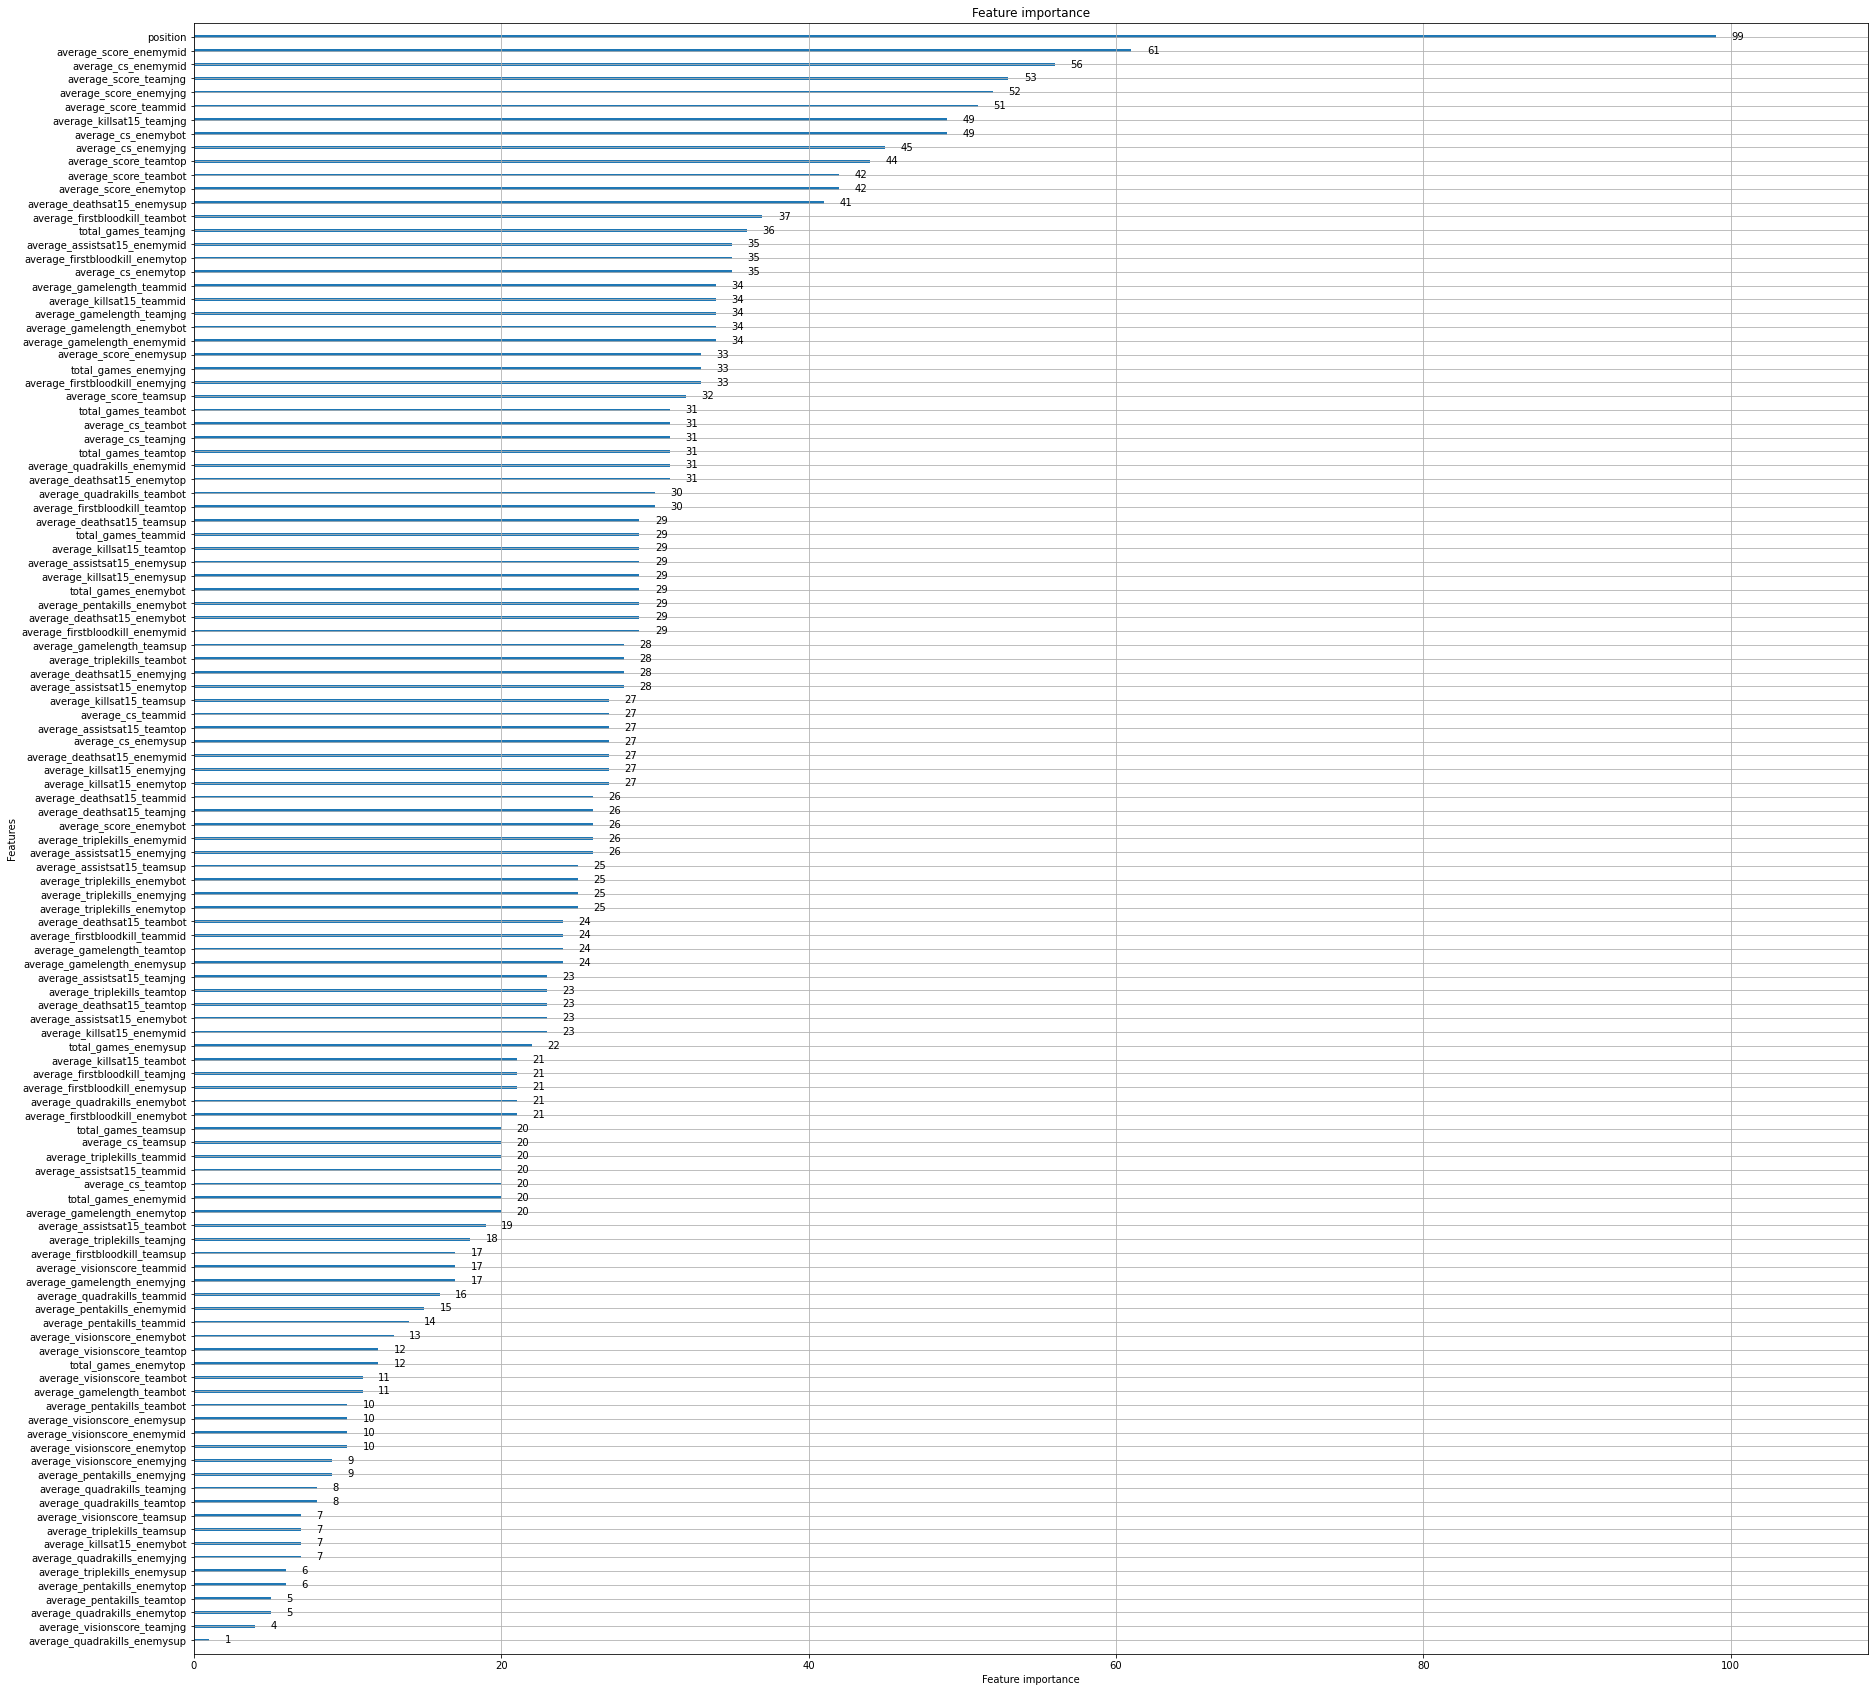

In [20]:
lightgbm.plot_importance(gbm1, figsize=(30,30))

plt.show()

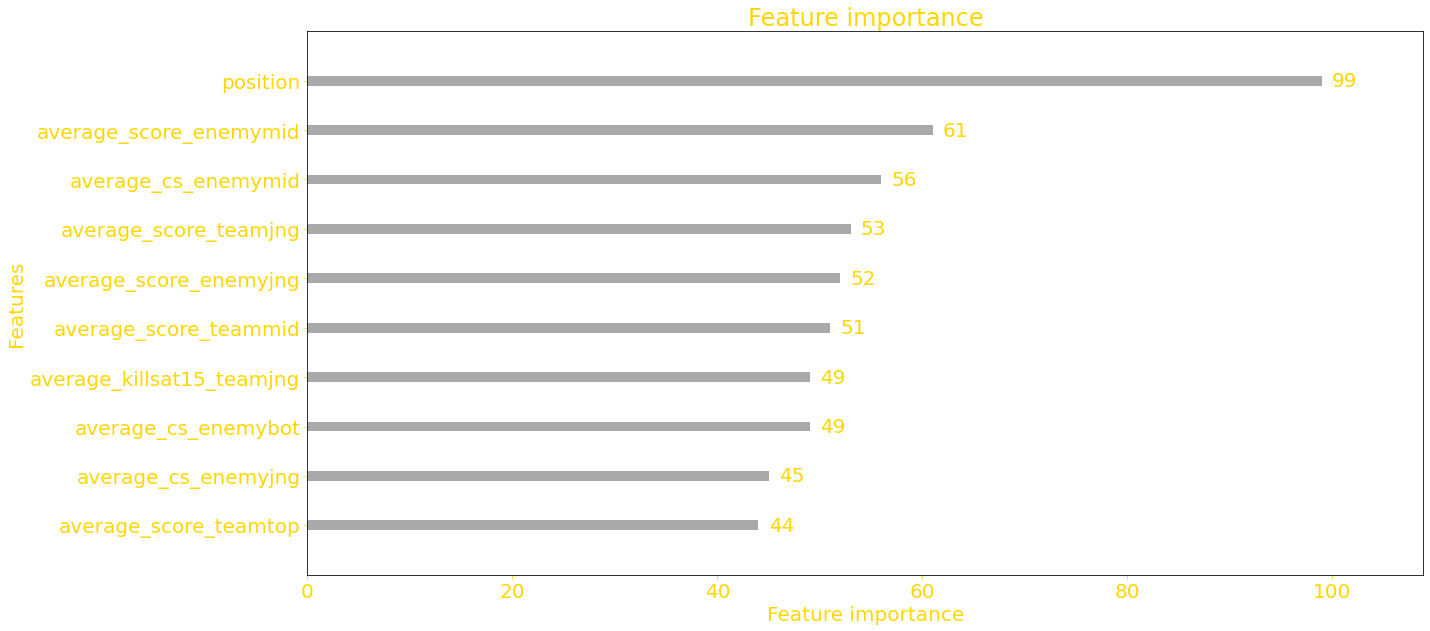

In [58]:
lightgbm.plot_importance(gbm1, figsize=(20,10), max_num_features=10, color='darkgrey')

plt.grid(b=None)
plt.rcParams.update({'font.size': 40})
plt.savefig('feat_imp2.png',  transparent=True,bbox_inches='tight')

plt.show()

C:\Users\IsDan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\IsDan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


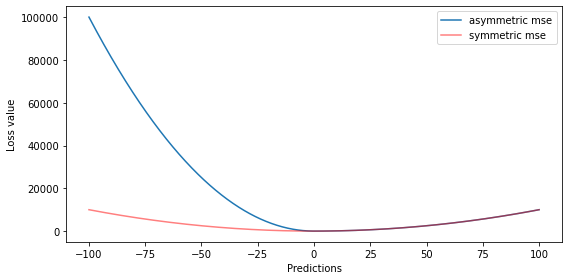

In [22]:
y_true = np.repeat(0,1000)
y_pred = np.linspace(-100,100,1000)
residual = (y_true - y_pred).astype("float")

custom_loss = np.where(residual > 0, (residual**2)*10.0, residual**2) 

fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.lineplot(y_pred, custom_loss, alpha=1, label="asymmetric mse")
sns.lineplot(y_pred, residual**2, alpha = 0.5, label = "symmetric mse", color="red")
ax.set_xlabel("Predictions")
ax.set_ylabel("Loss value")

fig.tight_layout()

C:\Users\IsDan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\IsDan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\IsDan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


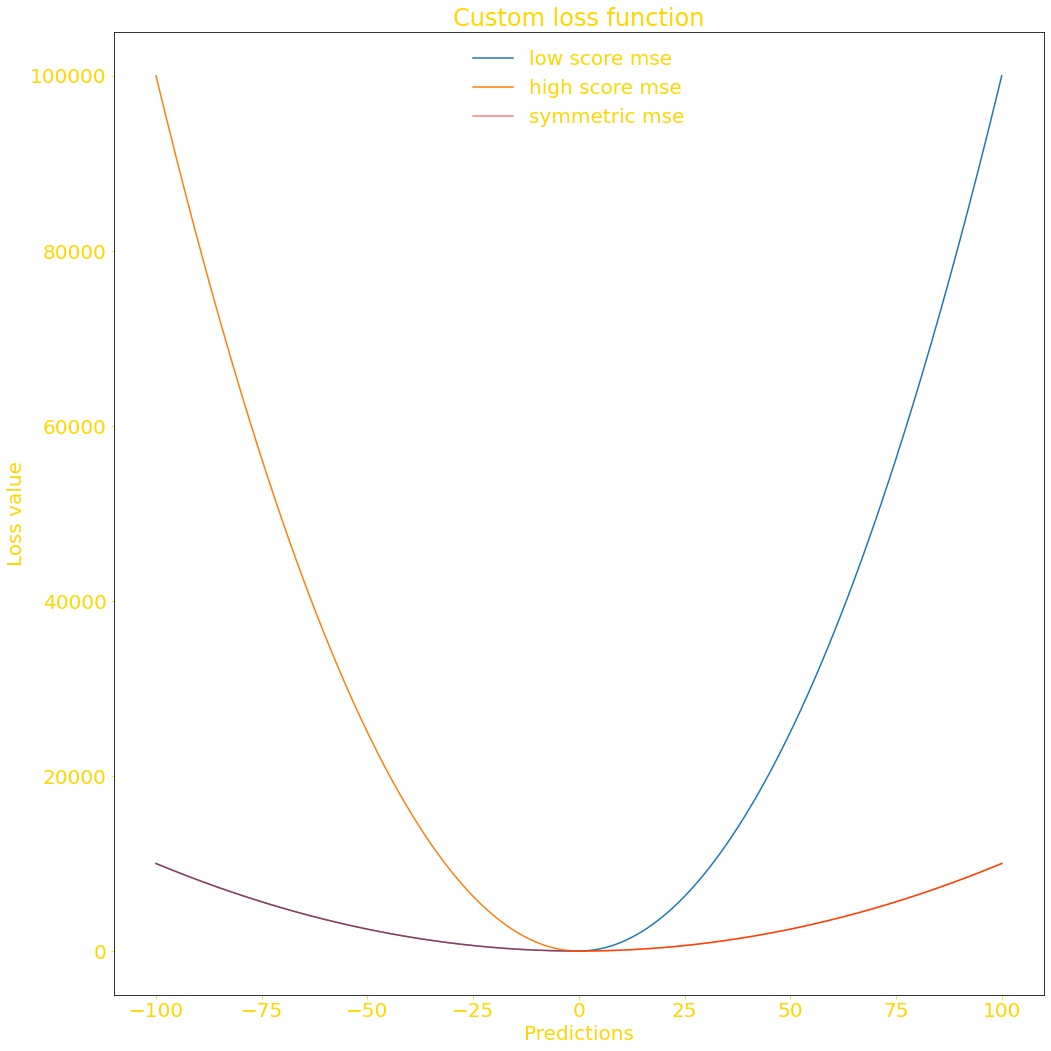

In [57]:
y_true = np.repeat(0,1000)
y_pred = np.linspace(-100,100,1000)
residual = (y_true - y_pred).astype("float")

low_score_loss = np.where(residual < 0, (residual**2)*10.0, residual**2) 
high_score_loss = np.where(residual > 0, (residual**2)*10.0, residual**2) 

fig, ax = plt.subplots(1,1, figsize=(15,15))
sns.lineplot(y_pred, low_score_loss, alpha=1, label="low score mse")
sns.lineplot(y_pred, high_score_loss, alpha=1, label="high score mse")
sns.lineplot(y_pred, residual**2, alpha = 0.5, label = "symmetric mse", color="red")
ax.set_xlabel("Predictions")
ax.set_ylabel("Loss value")
ax.set_title("Custom loss function")
ax.legend(loc='best', fancybox=True, framealpha=0)
plt.rcParams.update({'font.size': 20})
plt.savefig('clf.png',  transparent=True,bbox_inches='tight')

fig.tight_layout()

In [ ]:
def point_test(model, df, verbose=False):
    df.loc[:,'predicted_score_own'] = model.predict(df[features])

    max_pred = df.groupby(['week', 'position', 'playerid_own'])[['predicted_score_own']].mean()
    max_pred = max_pred.groupby(['week', 'position'])[['predicted_score_own']].max()
    max_pred = max_pred.reset_index().rename(columns={'predicted_score_own':'max_predicted_score'})
    df = pd.merge(df, max_pred, on=['week', 'position'], how='left')

    picks = df.groupby(['week','position', 'playerid_own'])[['max_score_own', 'score_own', 
                                                             'predicted_score_own', 'max_predicted_score']].mean().reset_index()
    picks = picks.loc[picks.score_own == picks.max_score_own]
    week =picks.week.unique()
    pos = picks.position.unique()
    combs = itertools.product(week, pos)
    back = pd.DataFrame()
    # to avoid picking multiple players when predicted scores match
    for i in combs:
        print(i)
        temp = picks[(picks.week == i[0]) &  (picks.position == i[1])]
        out = temp.iloc[0,:].to_frame().T
        back = pd.concat([back, out], axis=0)
    
    picks = back

    picks['missed_points'] = picks['max_score_own'] - picks['score_own']
    picks = picks.groupby('week')[['missed_points', 'score_own']].sum().reset_index()

    out = picks['score_own'][0] * 3
    for i in range(1,7):
        out += picks['score_own'][i] * 2
    out += picks['score_own'][7]*3
    
    if verbose:
        return picks
    else:
        return out


In [ ]:
point_test(gbm1, testing)

In [ ]:
maxim = testing.groupby(['week', 'position'])[['max_score_own']].mean().reset_index()
maxim = maxim.groupby(['week'])[['max_score_own']].sum()
maxim

In [ ]:
161.50*3 + 190.99*2 + 182.59*2 + 163.03*2 + 178.5*2 + 160.05*2 + 162.76*2 + 213.12*3